In [1]:
# General
import os
import gc
import json
from datetime import datetime, timedelta

# Data manipulation
import pandas as pd
import numpy as np
from numpy import nanmean
from pandas.tseries.offsets import MonthEnd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style, init
from prettytable import PrettyTable

# Machine Learning & Modeling
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import torch
import shap
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
)



c:\Users\samema\OneDrive\LV_Data\.venv\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed=42)

In [3]:
os.chdir('c:\\Users\\samema\\DB\\LV_Data2\\')

In [4]:


# Function to calculate the average SHAP values for each truncation label and model
def average_shap_values(shap_values_dict):
    average_shap_values_dict = {}
    for truncation_label, shap_info in shap_values_dict.items():
        shap_vals = np.array(shap_info['shap_values'])
        # Average SHAP values across instances and classes
        avg_shap_vals = np.mean(np.abs(shap_vals), axis=(0, 2)) if shap_vals.ndim == 3 else np.mean(np.abs(shap_vals), axis=0)
        print(f"SHAP values shape for {truncation_label}: {shap_vals.shape}")
        print(f"Averaged SHAP values shape for {truncation_label}: {avg_shap_vals.shape}")
        truncation_label_simplified = "_".join(truncation_label.split("_")[:-1])
        if truncation_label_simplified in average_shap_values_dict:
            average_shap_values_dict[truncation_label_simplified].append(avg_shap_vals)
        else:
            average_shap_values_dict[truncation_label_simplified] = [avg_shap_vals]
    return average_shap_values_dict

# Function to combine and average SHAP values across models for each truncation label
def combine_and_average_shap_values(average_shap_values_dict, feature_names):
    combined_df = pd.DataFrame()
    for truncation_label, avg_shap_vals_list in average_shap_values_dict.items():
        # Average SHAP values across models
        avg_shap_vals_across_models = np.mean(avg_shap_vals_list, axis=0)
        print(f"Processing {truncation_label}:")
        print(f" - Averaged SHAP values shape across models: {avg_shap_vals_across_models.shape}")
        print(f" - Feature names length: {len(feature_names)}")
        if len(avg_shap_vals_across_models) != len(feature_names):
            print(f"Length mismatch for {truncation_label}: {len(avg_shap_vals_across_models)} SHAP values vs {len(feature_names)} features")
            continue
        truncation_df = pd.DataFrame({
            'Feature': feature_names,
            'Mean SHAP Value': avg_shap_vals_across_models,
            'Truncation Label': truncation_label
        })
        combined_df = pd.concat([combined_df, truncation_df], ignore_index=True)
    return combined_df

# Function to plot combined SHAP values with scatter plot
def plot_combined_shap_values(combined_df):
    # Calculate the mean SHAP value for each feature across all truncation labels
    mean_shap_values = combined_df.groupby('Feature')['Mean SHAP Value'].mean().sort_values(ascending=False).reset_index()

    # Reverse the order to have the largest values at the top
    mean_shap_values = mean_shap_values[::-1]

    plt.figure(figsize=(14, 10))
    for label in combined_df['Truncation Label'].unique():
        subset = combined_df[combined_df['Truncation Label'] == label]
        subset_sorted = subset.set_index('Feature').loc[mean_shap_values['Feature']].reset_index()
        plt.scatter(subset_sorted['Mean SHAP Value'], subset_sorted['Feature'], label=label, alpha=0.7, s=100)
    
    plt.xlabel('Mean SHAP Value')
    plt.ylabel('Feature')
    plt.title('Average SHAP Values for Different Truncation Labels')
    plt.legend(title='Truncation Label')
    plt.tight_layout()
    plt.show()


In [5]:
df_full = pd.read_csv('df_full_2024_09_27.csv', )
df_test = pd.read_csv('df_full_test_2024_09_27.csv', )
df_30 = pd.read_csv('df_30_day_2024_09_27.csv', )
df_60 = pd.read_csv('df_60_day_2024_09_27.csv', )
df_90 = pd.read_csv('df_90_day_2024_09_27.csv', )

In [6]:
df_full['category'].value_counts()

category
low_risk            5310
medium_risk         3919
high_risk           1471
minimal_risk        1406
medium_high_risk    1176
low_medium_risk      644
Name: count, dtype: int64

In [7]:
# Function to combine minimal_risk and low_risk into low_risk
def combine_risk_categories(df):
    df['category'] = df['category'].replace('minimal_risk', 'low_risk')
    return df

# Apply the function to each DataFrame
df_full = combine_risk_categories(df_full)
df_30 = combine_risk_categories(df_30)
df_60 = combine_risk_categories(df_60)
df_90 = combine_risk_categories(df_90)


In [8]:
from sklearn.preprocessing import OrdinalEncoder

# Step 1: Ordinal Encoding
risk_categories = ['low_risk', 'low_medium_risk', 'medium_risk', 'medium_high_risk', 'high_risk']
encoder = OrdinalEncoder(categories=[risk_categories])

def encode_category(df):
    df['encoded_category'] = encoder.fit_transform(df[['category']])
    return df

df_full = encode_category(df_full)
df_test = encode_category(df_test)
df_30 = encode_category(df_30)
df_60 = encode_category(df_60)
df_90 = encode_category(df_90)

# Organize datasets into a dictionary
datasets = {
    'full_data': {'train': df_full, 'test': df_test},
    '30_day_data': {'train': df_30, 'test': df_test},
    '60_day_data': {'train': df_60, 'test': df_test},
    '90_day_data': {'train': df_90, 'test': df_test}
}

In [9]:
# Drop columns function
def drop_columns(datasets):
    for key, dataset in datasets.items():
        # Dropping columns and ensuring the dataset is updated
        dataset['train'] = dataset['train'].drop(columns=['category', 'date', 'Unnamed: 0','encoded_category'], errors='ignore')
        dataset['test'] = dataset['test'].drop(columns=['category', 'date', 'Unnamed: 0', 'encoded_category'], errors='ignore')
    return datasets



datasets = drop_columns(datasets)

In [10]:

# Define the manual category mapping
category_mapping = {
    0.0: 0,
    4.0: 1,
    2.0: 1,
    1.0: 1,
    3.0: 1
}

# Function to apply category mapping
def apply_manual_category_mapping(df, category_mapping):
    df['merged_category'] = df['encoded_category'].map(category_mapping)
    return df

# Apply category mappings to all datasets
datasets = {
    'full_data': {'train': apply_manual_category_mapping(df_full, category_mapping), 'test': apply_manual_category_mapping(df_test, category_mapping)},
    '30_day_data': {'train': apply_manual_category_mapping(df_30, category_mapping), 'test': apply_manual_category_mapping(df_test, category_mapping)},
    '60_day_data': {'train': apply_manual_category_mapping(df_60, category_mapping), 'test': apply_manual_category_mapping(df_test, category_mapping)},
    '90_day_data': {'train': apply_manual_category_mapping(df_90, category_mapping), 'test': apply_manual_category_mapping(df_test, category_mapping)}
}

# Verify the merged categories
for key, dataset in datasets.items():
    print(f"\n{key} - Train Merged Categories:")
    print(dataset['train']['merged_category'].value_counts())
    print(f"{key} - Test Merged Categories:")
    print(dataset['test']['merged_category'].value_counts())



full_data - Train Merged Categories:
merged_category
1    7210
0    6716
Name: count, dtype: int64
full_data - Test Merged Categories:
merged_category
1    1030
0     478
Name: count, dtype: int64

30_day_data - Train Merged Categories:
merged_category
1    7210
0    6716
Name: count, dtype: int64
30_day_data - Test Merged Categories:
merged_category
1    1030
0     478
Name: count, dtype: int64

60_day_data - Train Merged Categories:
merged_category
1    7210
0    6716
Name: count, dtype: int64
60_day_data - Test Merged Categories:
merged_category
1    1030
0     478
Name: count, dtype: int64

90_day_data - Train Merged Categories:
merged_category
1    7210
0    6716
Name: count, dtype: int64
90_day_data - Test Merged Categories:
merged_category
1    1030
0     478
Name: count, dtype: int64


In [11]:

# Function to train and evaluate the model and extract SHAP values
def train_and_evaluate(train_data, test_data, params):
    # Drop the 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in train_data.columns:
        train_data = train_data.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in test_data.columns:
        test_data = test_data.drop(columns=['Unnamed: 0'])
    
    X_train = train_data.drop(['merged_category', 'category', 'encoded_category'], axis=1)
    y_train = train_data['merged_category']
    X_test = test_data.drop(['merged_category', 'category', 'encoded_category'], axis=1)
    y_test = test_data['merged_category']
    
    model = xgb.XGBClassifier(
        learning_rate=params['xgb_learning_rate'],
        n_estimators=params['xgb_n_estimators'],
        max_depth=params['xgb_max_depth'],
        subsample=params['xgb_subsample'],
        colsample_bytree=params['xgb_colsample_bytree'],
        reg_alpha=params['xgb_reg_alpha'],
        reg_lambda=params['xgb_reg_lambda'],
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    model.fit(X_train, y_train)
    
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= params['threshold']).astype(int)
    
    # Calculate metrics
    metrics = {
        'roc_auc': roc_auc_score(y_test, y_prob),
        'f1_score': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    return metrics, shap_values, X_test.columns

# Function to calculate the average SHAP values for each truncation label and model
def average_shap_values(shap_values_dict):
    average_shap_values_dict = {}
    for truncation_label, shap_info in shap_values_dict.items():
        shap_vals = np.array(shap_info['shap_values'])
        # Average SHAP values across instances and classes
        avg_shap_vals = np.mean(np.abs(shap_vals), axis=0)
        print(f"SHAP values shape for {truncation_label}: {shap_vals.shape}")
        print(f"Averaged SHAP values shape for {truncation_label}: {avg_shap_vals.shape}")
        truncation_label_simplified = "_".join(truncation_label.split("_")[:-1])
        if truncation_label_simplified in average_shap_values_dict:
            average_shap_values_dict[truncation_label_simplified].append(avg_shap_vals)
        else:
            average_shap_values_dict[truncation_label_simplified] = [avg_shap_vals]
    return average_shap_values_dict

# Function to combine and average SHAP values across models for each truncation label
def combine_and_average_shap_values(average_shap_values_dict, feature_names):
    combined_df = pd.DataFrame()
    for truncation_label, avg_shap_vals_list in average_shap_values_dict.items():
        # Average SHAP values across models
        avg_shap_vals_across_models = np.mean(avg_shap_vals_list, axis=0)
        truncation_df = pd.DataFrame({
            'Feature': feature_names,
            'Mean SHAP Value': avg_shap_vals_across_models,
            'Truncation Label': truncation_label
        })
        combined_df = pd.concat([combined_df, truncation_df], ignore_index=True)
    return combined_df

# Function to plot combined SHAP values with scatter plot
def plot_combined_shap_values(combined_df):
    # Calculate the mean SHAP value for each feature across all truncation labels
    mean_shap_values = combined_df.groupby('Feature')['Mean SHAP Value'].mean().sort_values(ascending=False).reset_index()

    # Reverse the order to have the largest values at the top
    mean_shap_values = mean_shap_values[::-1]

    plt.figure(figsize=(14, 10))
    for label in combined_df['Truncation Label'].unique():
        subset = combined_df[combined_df['Truncation Label'] == label]
        subset_sorted = subset.set_index('Feature').loc[mean_shap_values['Feature']].reset_index()
        plt.scatter(subset_sorted['Mean SHAP Value'], subset_sorted['Feature'], label=label, alpha=0.7, s=100)
    
    plt.xlabel('Mean SHAP Value')
    plt.ylabel('Feature')
    plt.title('Average SHAP Values for Different Truncation Labels')
    plt.legend(title='Truncation Label')
    plt.tight_layout()
    plt.show()

# F0.5 optimized hyperparameters for each dataset
hyperparameters_f05 = {
    "30_day_data_f0_5": {
        "xgb_learning_rate": 0.019563242594239555,
        "xgb_n_estimators": 447,
        "xgb_max_depth": 6,
        "xgb_subsample": 0.5434875318249134,
        "xgb_colsample_bytree": 0.7872113805868453,
        "xgb_reg_alpha": 2.5928035606814204e-06,
        "xgb_reg_lambda": 0.039597023611128684,
        "threshold": 0.3681383293691303
    },
    "60_day_data_f0_5": {
        "xgb_learning_rate": 0.019249574006961225,
        "xgb_n_estimators": 485,
        "xgb_max_depth": 10,
        "xgb_subsample": 0.9517410406994253,
        "xgb_colsample_bytree": 0.8025330979675196,
        "xgb_reg_alpha": 2.0138695711952252e-07,
        "xgb_reg_lambda": 0.0033877497870979435,
        "threshold": 0.41379390804243016
    },
    "90_day_data_f0_5": {
        "xgb_learning_rate": 0.04291890485252391,
        "xgb_n_estimators": 432,
        "xgb_max_depth": 10,
        "xgb_subsample": 0.9922023280232749,
        "xgb_colsample_bytree": 0.9515800000478695,
        "xgb_reg_alpha": 0.03286960800147199,
        "xgb_reg_lambda": 0.033657844754733234,
        "threshold": 0.44280934130111194
    },
    "full_data_f0_5": {
        "xgb_learning_rate": 0.08144357664940434,
        "xgb_n_estimators": 443,
        "xgb_max_depth": 9,
        "xgb_subsample": 0.9795493763911559,
        "xgb_colsample_bytree": 0.9657780547762558,
        "xgb_reg_alpha": 0.0008864641272450883,
        "xgb_reg_lambda": 2.3393720416665804e-05,
        "threshold": 0.4183726688437836
    }
}

# Training and evaluation
results = {}
shap_values_dict = {}
for key, params in hyperparameters_f05.items():
    if 'full_data' in key:
        data_key = 'full_data'
    else:
        data_key = key.split('_')[0] + '_day_data'
    train_data = datasets[data_key]['train']
    test_data = datasets[data_key]['test']
    metrics, shap_values, feature_names = train_and_evaluate(train_data, test_data, params)
    results[key] = metrics
    shap_values_dict[key] = {'shap_values': shap_values, 'feature_names': feature_names}

# Average SHAP values calculation
average_shap_values_dict = average_shap_values(shap_values_dict)

# Combine and average SHAP values
combined_df = combine_and_average_shap_values(average_shap_values_dict, feature_names)

# Plot combined SHAP values
plot_combined_shap_values(combined_df)

# Display results
for key, metrics in results.items():
    print(f"Results for {key}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print("\n")


NameError: name 'confusion_matrix' is not defined

[14:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


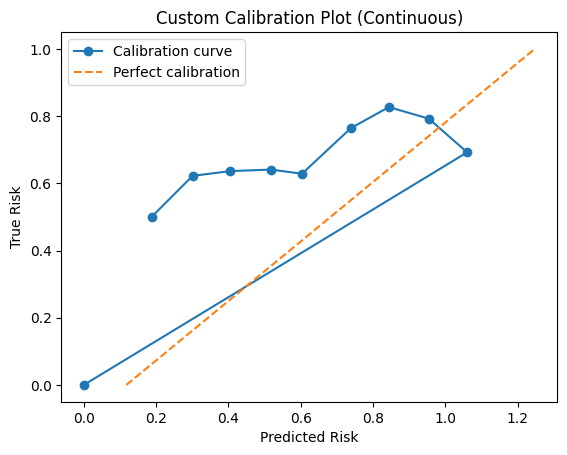


Binned Metrics (Pseudo-AUC):
     bins    y_true    y_pred
0     Low  0.548387  0.245245
1  Medium  0.615681  0.515165
2    High  0.762887  0.748597

Comparison Across Risk Categories:
Low Risk - True Mean: 0.5483870967741935, Predicted Mean: 0.24524500966072083
Medium Risk - True Mean: 0.615681233933162, Predicted Mean: 0.515165388584137
High Risk - True Mean: 0.7639484978540773, Predicted Mean: 0.7573992013931274


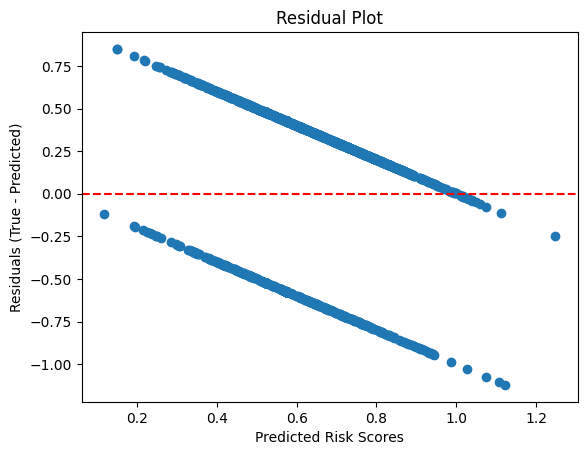

[14:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


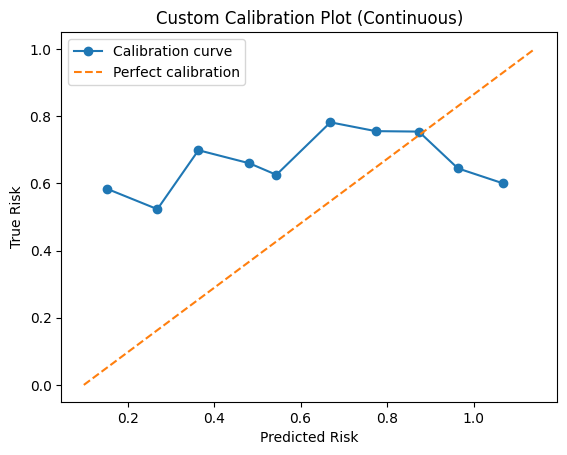


Binned Metrics (Pseudo-AUC):
     bins    y_true    y_pred
0     Low  0.515625  0.240042
1  Medium  0.647904  0.483374
2    High  0.749164  0.760498

Comparison Across Risk Categories:
Low Risk - True Mean: 0.515625, Predicted Mean: 0.24004215002059937
Medium Risk - True Mean: 0.6479041916167665, Predicted Mean: 0.48337435722351074
High Risk - True Mean: 0.7487684729064039, Predicted Mean: 0.7657256722450256


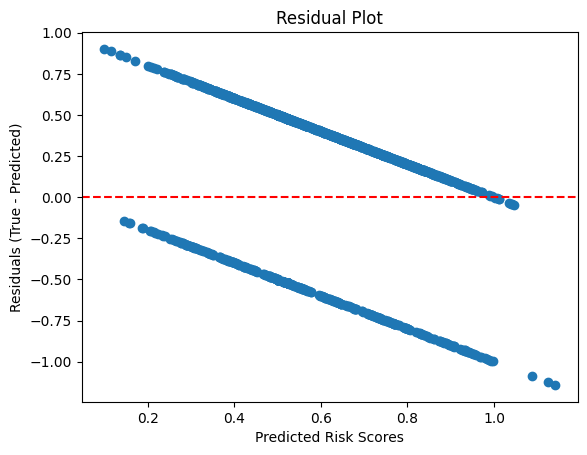

[14:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


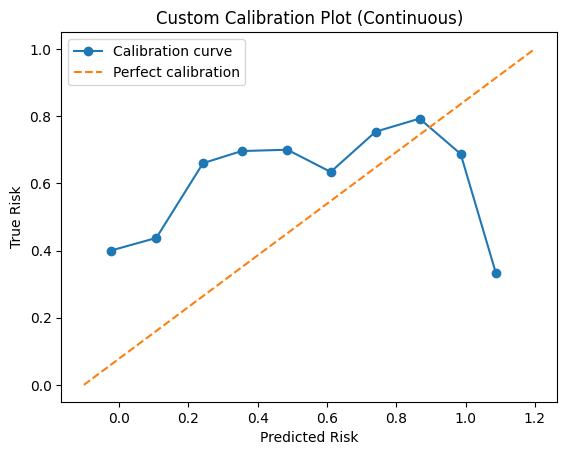


Binned Metrics (Pseudo-AUC):
     bins    y_true    y_pred
0     Low  0.589744  0.211844
1  Medium  0.648649  0.514821
2    High  0.731343  0.736720

Comparison Across Risk Categories:
Low Risk - True Mean: 0.5875, Predicted Mean: 0.20468707382678986
Medium Risk - True Mean: 0.6486486486486487, Predicted Mean: 0.5148213505744934
High Risk - True Mean: 0.7230971128608924, Predicted Mean: 0.746881902217865


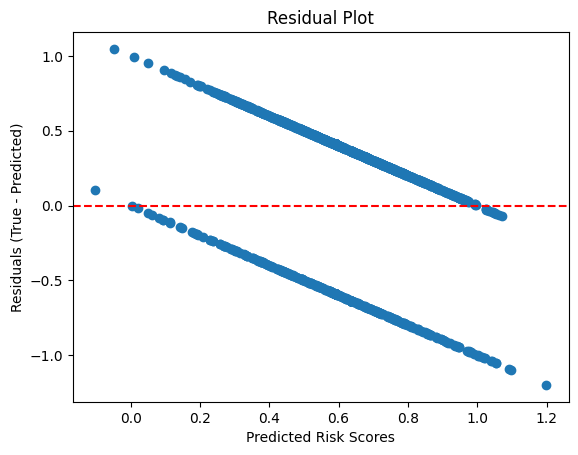

[14:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


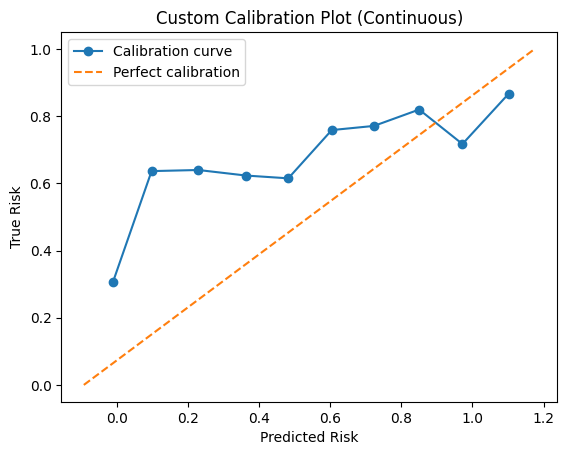


Binned Metrics (Pseudo-AUC):
     bins    y_true    y_pred
0     Low  0.615385  0.182837
1  Medium  0.634881  0.455900
2    High  0.778905  0.750989

Comparison Across Risk Categories:
Low Risk - True Mean: 0.6203208556149733, Predicted Mean: 0.1765986979007721
Medium Risk - True Mean: 0.6348808030112923, Predicted Mean: 0.45589977502822876
High Risk - True Mean: 0.7786259541984732, Predicted Mean: 0.7694916725158691


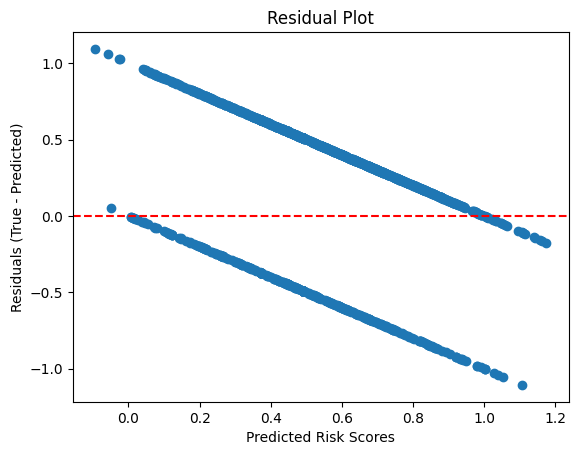

SHAP values shape for 30_day_data_f0_5: (1508, 48)
Averaged SHAP values shape for 30_day_data_f0_5: (48,)
SHAP values shape for 60_day_data_f0_5: (1508, 48)
Averaged SHAP values shape for 60_day_data_f0_5: (48,)
SHAP values shape for 90_day_data_f0_5: (1508, 48)
Averaged SHAP values shape for 90_day_data_f0_5: (48,)
SHAP values shape for full_data_f0_5: (1508, 48)
Averaged SHAP values shape for full_data_f0_5: (48,)


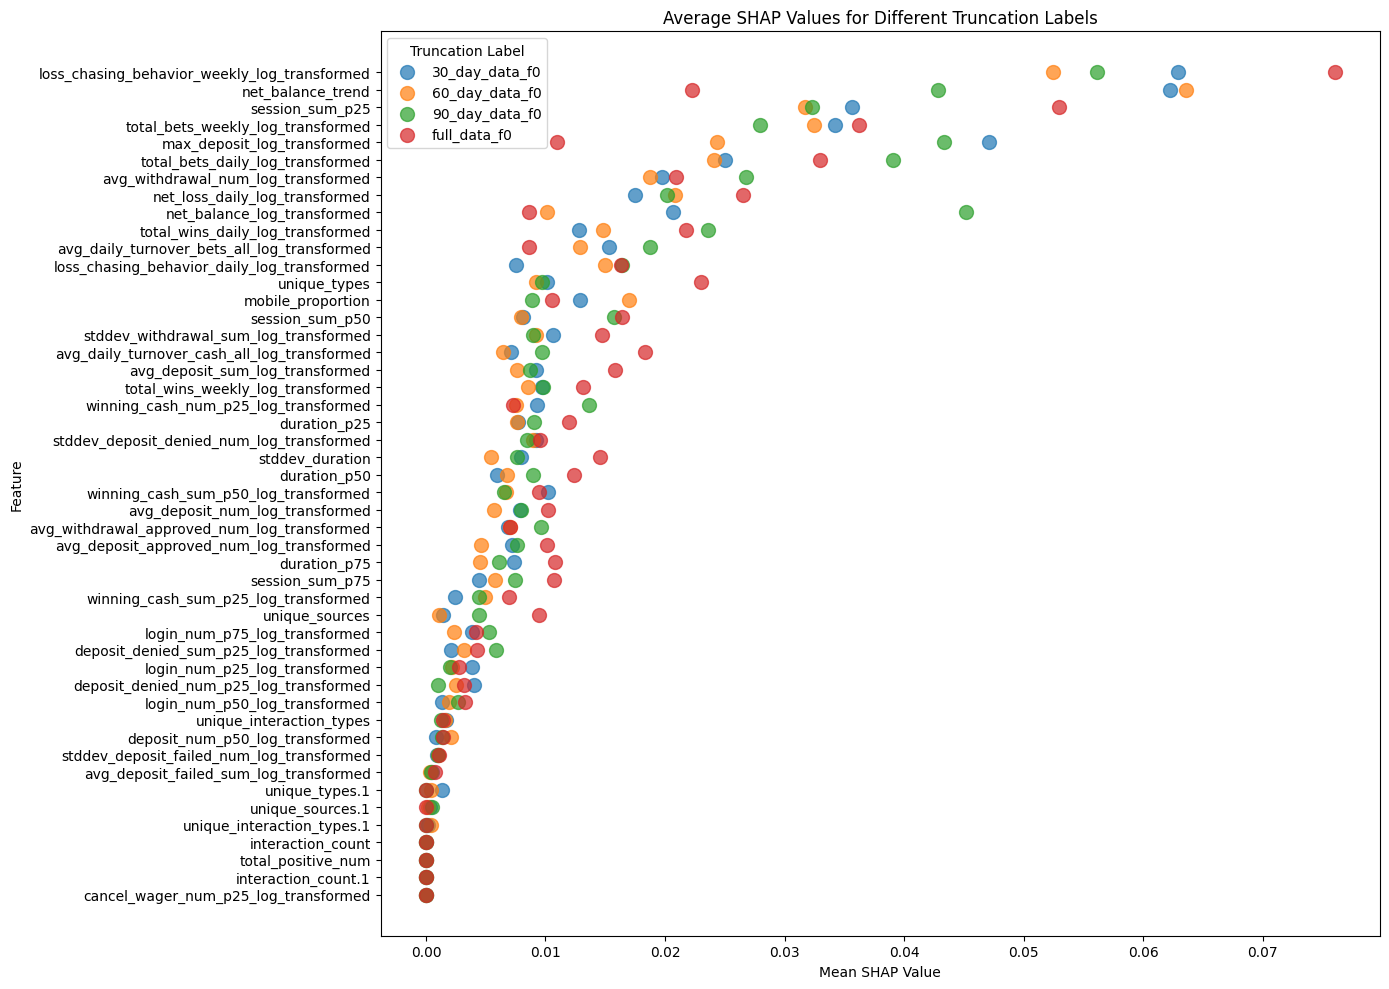

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Function to bin risk scores into categories
def categorize_risk(score, low_threshold=0.3, high_threshold=0.6):
    if score < low_threshold:
        return "Low Risk"
    elif score < high_threshold:
        return "Medium Risk"
    else:
        return "High Risk"

# Function to train and evaluate the model and extract SHAP values for regression
def train_and_evaluate(train_data, test_data, params):
    # Drop the 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in train_data.columns:
        train_data = train_data.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in test_data.columns:
        test_data = test_data.drop(columns=['Unnamed: 0'])
    
    X_train = train_data.drop(['merged_category', 'category', 'encoded_category'], axis=1)
    y_train = train_data['merged_category']
    X_test = test_data.drop(['merged_category', 'category', 'encoded_category'], axis=1)
    y_test = test_data['merged_category']
    
    model = xgb.XGBRegressor(
        learning_rate=params['xgb_learning_rate'],
        n_estimators=params['xgb_n_estimators'],
        max_depth=params['xgb_max_depth'],
        subsample=params['xgb_subsample'],
        colsample_bytree=params['xgb_colsample_bytree'],
        reg_alpha=params['xgb_reg_alpha'],
        reg_lambda=params['xgb_reg_lambda'],
        eval_metric='rmse'
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Calculate regression metrics
    metrics = {
        'mean_squared_error': mean_squared_error(y_test, y_pred),
        'mean_absolute_error': mean_absolute_error(y_test, y_pred),
        'r2_score': r2_score(y_test, y_pred)
    }

    # Categorize predicted scores into risk levels
    risk_categories = [categorize_risk(score) for score in y_pred]
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    return metrics, shap_values, X_test.columns, y_pred, risk_categories, y_test

# Function to normalize the predicted risk scores to [0, 1]
def normalize_predictions(y_pred):
    scaler = MinMaxScaler()
    y_pred_normalized = scaler.fit_transform(y_pred.reshape(-1, 1)).flatten()
    return y_pred_normalized

# Custom calibration plot function for regression
def plot_custom_calibration_curve(y_test, y_pred, n_bins=10):
    # Bin the predictions into equal intervals
    bins = np.linspace(y_pred.min(), y_pred.max(), n_bins + 1)
    bin_indices = np.digitize(y_pred, bins) - 1  # Get indices for each bin
    
    bin_means_pred = np.zeros(n_bins)
    bin_means_true = np.zeros(n_bins)

    # For each bin, calculate the mean predicted and true values
    for i in range(n_bins):
        bin_means_pred[i] = y_pred[bin_indices == i].mean() if len(y_pred[bin_indices == i]) > 0 else 0
        bin_means_true[i] = y_test[bin_indices == i].mean() if len(y_test[bin_indices == i]) > 0 else 0

    # Plot the custom calibration curve
    plt.plot(bin_means_pred, bin_means_true, marker='o', label='Calibration curve')
    plt.plot([y_pred.min(), y_pred.max()], [y_test.min(), y_test.max()], linestyle='--', label='Perfect calibration')
    plt.title("Custom Calibration Plot (Continuous)")
    plt.xlabel("Predicted Risk")
    plt.ylabel("True Risk")
    plt.legend()
    plt.show()

# Function to calculate and display binned metrics (pseudo-AUC)
def binned_metrics(y_test, y_pred, bins=[0, 0.3, 0.6, 1.0]):
    # Binning the predictions
    binned_pred = pd.cut(y_pred, bins=bins, labels=["Low", "Medium", "High"])
    
    # Create a DataFrame to group the values
    results_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred, 'bins': binned_pred})
    
    # Group by bin and calculate mean true outcome and predicted score
    binned_stats = results_df.groupby('bins').agg({
        'y_true': 'mean',
        'y_pred': 'mean'
    }).reset_index()
    
    print("\nBinned Metrics (Pseudo-AUC):")
    print(binned_stats)
    
    return binned_stats

# Function to compare performance across risk categories
def compare_risk_categories(y_test, y_pred, low_threshold=0.3, high_threshold=0.6):
    low_risk_group = (y_pred <= low_threshold)
    medium_risk_group = (y_pred > low_threshold) & (y_pred <= high_threshold)
    high_risk_group = (y_pred > high_threshold)

    print(f"\nComparison Across Risk Categories:")
    print(f"Low Risk - True Mean: {y_test[low_risk_group].mean()}, Predicted Mean: {y_pred[low_risk_group].mean()}")
    print(f"Medium Risk - True Mean: {y_test[medium_risk_group].mean()}, Predicted Mean: {y_pred[medium_risk_group].mean()}")
    print(f"High Risk - True Mean: {y_test[high_risk_group].mean()}, Predicted Mean: {y_pred[high_risk_group].mean()}")

# Function to plot residuals
def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted Risk Scores')
    plt.ylabel('Residuals (True - Predicted)')
    plt.title('Residual Plot')
    plt.show()

# F0.5 optimized hyperparameters for each dataset (for regression)
hyperparameters_f05 = {
    "30_day_data_f0_5": {
        "xgb_learning_rate": 0.019563242594239555,
        "xgb_n_estimators": 447,
        "xgb_max_depth": 6,
        "xgb_subsample": 0.5434875318249134,
        "xgb_colsample_bytree": 0.7872113805868453,
        "xgb_reg_alpha": 2.5928035606814204e-06,
        "xgb_reg_lambda": 0.039597023611128684,
    },
    "60_day_data_f0_5": {
        "xgb_learning_rate": 0.019249574006961225,
        "xgb_n_estimators": 485,
        "xgb_max_depth": 10,
        "xgb_subsample": 0.9517410406994253,
        "xgb_colsample_bytree": 0.8025330979675196,
        "xgb_reg_alpha": 2.0138695711952252e-07,
        "xgb_reg_lambda": 0.0033877497870979435,
    },
    "90_day_data_f0_5": {
        "xgb_learning_rate": 0.04291890485252391,
        "xgb_n_estimators": 432,
        "xgb_max_depth": 10,
        "xgb_subsample": 0.9922023280232749,
        "xgb_colsample_bytree": 0.9515800000478695,
        "xgb_reg_alpha": 0.03286960800147199,
        "xgb_reg_lambda": 0.033657844754733234,
    },
    "full_data_f0_5": {
        "xgb_learning_rate": 0.08144357664940434,
        "xgb_n_estimators": 443,
        "xgb_max_depth": 9,
        "xgb_subsample": 0.9795493763911559,
        "xgb_colsample_bytree": 0.9657780547762558,
        "xgb_reg_alpha": 0.0008864641272450883,
        "xgb_reg_lambda": 2.3393720416665804e-05,
    }
}

# Training and evaluation for regression
results = {}
shap_values_dict = {}
risk_results = {}

for key, params in hyperparameters_f05.items():
    if 'full_data' in key:
        data_key = 'full_data'
    else:
        data_key = key.split('_')[0] + '_day_data'
    train_data = datasets[data_key]['train']
    test_data = datasets[data_key]['test']
    
    metrics, shap_values, feature_names, y_pred, risk_categories, y_test = train_and_evaluate(train_data, test_data, params)
    
    results[key] = metrics
    shap_values_dict[key] = {'shap_values': shap_values, 'feature_names': feature_names}
    risk_results[key] = list(zip(y_pred, risk_categories))  # Store risk scores and categories for reporting

    # Plot custom calibration curve
    plot_custom_calibration_curve(y_test, y_pred)
    
    # Display binned metrics (pseudo-AUC)
    binned_metrics(y_test, y_pred)
    
    # Compare performance across risk categories
    compare_risk_categories(y_test, y_pred)
    
    # Plot residuals
    plot_residuals(y_test, y_pred)

# Average SHAP values calculation
average_shap_values_dict = average_shap_values(shap_values_dict)

# Combine and average SHAP values
combined_df = combine_and_average_shap_values(average_shap_values_dict, feature_names)

# Plot combined SHAP values
plot_combined_shap_values(combined_df)


In [ ]:

# Function to compare performance across risk categories and return the means
def compare_risk_categories(y_test, y_pred, low_threshold=0.3, high_threshold=0.6):
    low_risk_group = (y_pred <= low_threshold)
    medium_risk_group = (y_pred > low_threshold) & (y_pred <= high_threshold)
    high_risk_group = (y_pred > high_threshold)

    low_true_mean = y_test[low_risk_group].mean()
    low_pred_mean = y_pred[low_risk_group].mean()

    medium_true_mean = y_test[medium_risk_group].mean()
    medium_pred_mean = y_pred[medium_risk_group].mean()

    high_true_mean = y_test[high_risk_group].mean()
    high_pred_mean = y_pred[high_risk_group].mean()

    return {
        'Low Risk': {'True Mean': low_true_mean, 'Predicted Mean': low_pred_mean},
        'Medium Risk': {'True Mean': medium_true_mean, 'Predicted Mean': medium_pred_mean},
        'High Risk': {'True Mean': high_true_mean, 'Predicted Mean': high_pred_mean},
    }

# Function to create a DataFrame for comparison across all datasets
def create_comparison_table(results_dict):
    data = {
        'Dataset': [],
        'Risk Category': [],
        'True Mean': [],
        'Predicted Mean': []
    }

    for dataset_name, risk_means in results_dict.items():
        for risk_category, means in risk_means.items():
            data['Dataset'].append(dataset_name)
            data['Risk Category'].append(risk_category)
            data['True Mean'].append(means['True Mean'])
            data['Predicted Mean'].append(means['Predicted Mean'])

    # Convert to DataFrame
    comparison_df = pd.DataFrame(data)
    return comparison_df

# Collecting the comparison across risk categories for each dataset
results_with_risk_comparison = {}

for key, params in hyperparameters_f05.items():
    if 'full_data' in key:
        data_key = 'full_data'
    else:
        data_key = key.split('_')[0] + '_day_data'

    train_data = datasets[data_key]['train']
    test_data = datasets[data_key]['test']

    metrics, shap_values, feature_names, y_pred, risk_categories, y_test = train_and_evaluate(train_data, test_data, params)

    # Store comparison across risk categories
    results_with_risk_comparison[key] = compare_risk_categories(y_test, y_pred)

# Creating the comparison table and displaying it
comparison_table = create_comparison_table(results_with_risk_comparison)
print(comparison_table)


[14:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[14:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[14:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[14:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-au

             Dataset Risk Category  True Mean  Predicted Mean
0   30_day_data_f0_5      Low Risk   0.548387        0.245245
1   30_day_data_f0_5   Medium Risk   0.615681        0.515165
2   30_day_data_f0_5     High Risk   0.763948        0.757399
3   60_day_data_f0_5      Low Risk   0.515625        0.240042
4   60_day_data_f0_5   Medium Risk   0.647904        0.483374
5   60_day_data_f0_5     High Risk   0.748768        0.765726
6   90_day_data_f0_5      Low Risk   0.587500        0.204687
7   90_day_data_f0_5   Medium Risk   0.648649        0.514821
8   90_day_data_f0_5     High Risk   0.723097        0.746882
9     full_data_f0_5      Low Risk   0.620321        0.176599
10    full_data_f0_5   Medium Risk   0.634881        0.455900
11    full_data_f0_5     High Risk   0.778626        0.769492
